In [1]:
%matplotlib inline

from joblib import dump, load
import itertools
import json
import math
import os
import random
import time
from typing import Callable, Dict, List

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# scikit-learn
import sklearn
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, \
    f1_score, fbeta_score, log_loss, make_scorer, mean_squared_error, precision_recall_fscore_support, \
    precision_score, precision_recall_curve, recall_score
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC

# statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Models
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

# NLP
import gc
import re
import string
import operator
from collections import defaultdict




# Configure options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 11

random.seed(random_state)
np.random.seed(random_state)

In [3]:
root = '/home/jovyan/work'

df = pd.read_csv(root + '/Downloads/diabetes.csv')

In [4]:
len(df)

70000

In [10]:
df[df.duplicated()]

,id,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,pressure,diabetes


In [11]:
df.head()

,id,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,pressure,diabetes
0,0,18393,f,168,62.0,low,low,0,0,1,110/80,0
1,1,20228,m,156,85.0,high,low,0,0,1,140/90,0
2,2,18857,m,165,64.0,high,low,0,0,0,130/70,0
3,3,17623,f,169,82.0,low,low,0,0,1,150/100,0
4,4,17474,m,156,56.0,low,low,0,0,0,100/60,0


In [26]:
def get_types(df):
    dtypes = defaultdict(list)
    for col, dtype in df.dtypes.items():
        dtypes[str(dtype)].append(col)
    return dtypes

get_types(df)

defaultdict(list,
            {'int64': ['id',
              'age',
              'height',
              'smoke',
              'alco',
              'active',
              'diabetes'],
             'object': ['gender', 'cholesterol', 'gluc', 'pressure'],
             'float64': ['weight'],
             'int16': ['high_pressure', 'low_pressure']})

In [24]:
df['low_pressure'] = df['pressure'].str.split('/')[0][1]
df['low_pressure'] = df['low_pressure'].astype(np.int16)

df['high_pressure'] = df['pressure'].str.split('/')[0][0]
df['high_pressure'] = df['high_pressure'].astype(np.int16)

In [27]:
def get_dummies_drop_level_and_join(df, column, level_to_drop):
    dummies = pd.get_dummies(df[column]).drop([level_to_drop], axis=1)
    return df.join(dummies).drop(column, axis=1)

In [58]:
df_processed = df.drop('pressure', axis=1)
categorical_cols = ['gender', 'cholesterol', 'gluc']
df_processed = df_processed.join(pd.get_dummies(df[categorical_cols], drop_first=True)).drop(
    categorical_cols, axis=1
)
df_processed.columns

Index(['id', 'age', 'height', 'weight', 'smoke', 'alco', 'active', 'diabetes', 'high_pressure', 'low_pressure', 'gender_m', 'cholesterol_low', 'cholesterol_medium', 'gluc_low', 'gluc_medium'], dtype='object')

In [59]:
df_processed = df_processed.drop('id', axis=1)

In [12]:
target = 'diabetes'

In [60]:
x = df_processed.drop(target, axis=1).values
y = df_processed[target].values

In [66]:
xtrain, xtest, ytrain, ytest = train_test_split(
    *[x, y], random_state=random_state, test_size=.2, stratify=y)

cv = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
clf = XGBClassifier()

In [67]:
cross_validate(clf, xtrain, ytrain, scoring=make_scorer(accuracy_score), cv=cv)

{'fit_time': array([1.04246521, 0.99569011, 1.02209425, 0.98024392, 0.99937034]),
 'score_time': array([0.01460671, 0.01385331, 0.01960015, 0.01667643, 0.01576853]),
 'test_score': array([0.94776786, 0.94803571, 0.950625  , 0.95017857, 0.94544643])}

In [43]:
clf = clf.fit(xtrain, ytrain)
pred_probas = clf.predict_proba(xtest)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb27f8ce438>]],
      dtype=object)

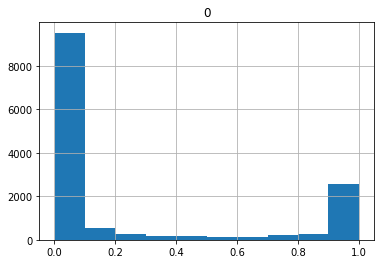

In [45]:
pd.DataFrame(pred_probas[:, 1]).hist()

In [64]:
preds = np.array([0 if prob < .5 else 1 for prob in pred_probas[:, 1]])
accuracy_score(ytest, preds)

0.9464285714285714

In [54]:
for params in [
    (0.1, 9),
    (.3, 9),
    (0.5, 9)
]:
    print(params)
    clf = XGBClassifier(learning_rate=params[0], max_depth=params[1])
    print(cross_validate(clf, xtrain, ytrain, scoring=make_scorer(accuracy_score), cv=cv))
    

(0.1, 9)
{'fit_time': array([1.92388892, 2.08819175, 2.1951654 , 2.05064487, 2.13600445]), 'score_time': array([0.02730799, 0.02722287, 0.03424358, 0.03177786, 0.02965307]), 'test_score': array([0.94821429, 0.94839286, 0.95044643, 0.94839286, 0.94857143])}
(0.3, 9)
{'fit_time': array([2.12365842, 2.16420913, 1.91396308, 1.87248373, 1.92219901]), 'score_time': array([0.02664018, 0.02578092, 0.02702546, 0.02563834, 0.02769208]), 'test_score': array([0.94714286, 0.94580357, 0.94848214, 0.94714286, 0.94776786])}
(0.5, 9)
{'fit_time': array([1.93923521, 1.80526376, 1.85535622, 1.83665109, 1.91323543]), 'score_time': array([0.0250771 , 0.02799511, 0.02595758, 0.0253346 , 0.02770901]), 'test_score': array([0.94383929, 0.94321429, 0.94767857, 0.94758929, 0.94544643])}


In [ ]:
# from hyperopt import hp
# from hyperopt.pyll.base import scope
# from xgboost import XGBClassifier

# from src.train import score_func

# # Haven't found a paper yet that gives the best parameters
# xgb_classifier_space = {
#     # mlm - 50 - 400
#     # n_estimators
#     # av - 3 - 10
#     # # kaggle tilii7 - 3-5
#     # tds - hp tuning the smart way - 3 - 15
#     'max_depth': scope.int(hp.quniform('max_depth', 1, 9, 1)),
#     # av - .01 - .2
#     # tds - hp tuning the smart way - .05 - .3
#     'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
#     # 'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
#     # Don't tune the booster. AnalyticsVidhya says gblinear rarely used, and
#     # XGB documentation says dart is slow.
#     # 'booster': hp.choice(['gbtree', 'dart']),
#     # Already parallelzing cv training
#     'n_jobs': 1,
#     # kaggle tilii7 - .5 - 5 with .5 step
#     # tds - hp tuning the smart way - 0 - .4 with .1 step
#     'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
#     # kaggle tilii7 - 1-10
#     'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 6, 1)),
#     'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
#     # tds - hp tuning the smart way - .3 - .7
#     'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
# }


# def xgb_pipeline_factory(**params):
#     """
#     From xgboost documentation: https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=n_estimators
#     "**kwargs is unsupported by scikit-learn. We do not guarantee that parameters passed via this argument will
#     interact properly with scikit-learn."
#     :param params:
#     :return:
#     """
#     return XGBClassifier(
#         learning_rate=params['learning_rate'],
#         max_depth=params['max_depth'],
#         min_child_weight=params['min_child_weight'],
#         subsample=params['subsample'],
#         gamma=params['gamma'],
#         colsample_bytree=params['colsample_bytree'],
#     )


# def score_func_with_defaults(params):
#     pipeline_output_dir = "/home/jovyan/work/data/ultimate_challenge/pipelines"
#     return score_func(random_state=random_state,
#                       pipeline_factory=xgb_pipeline_factory,
#                       pipeline_output_dir=pipeline_output_dir,
#                       n_jobs=n_jobs,
#                       pipeline_name=pipeline_name,
#                       scoring=scoring,
#                       xtrain=xtrain,
#                       ytrain=ytrain,
#                       params=params)


In [68]:
clf = RandomForestClassifier()
clf = clf.fit(xtrain, ytrain)
pred_probas = clf.predict_proba(xtest)
preds = np.array([0 if prob < .5 else 1 for prob in pred_probas[:, 1]])
accuracy_score(ytest, preds)

0.9486428571428571